<a href="https://colab.research.google.com/github/VP20789/SQL-Projects/blob/main/Vaibhav_Patil_DSDEAI_B21_Deep_Learning_Assignment_SMS_Spam_Detection_using_Vanilla_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [64]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping

import warnings
warnings.filterwarnings("ignore")

# pandas → load & clean dataset

# numpy → numerical operations

# matplotlib/seaborn → plotting graphs

# sklearn → splitting data & evaluation metrics

# tensorflow.keras → building RNN model

# Tasks & Deliverables
## Task A — Data Cleaning & Exploration (Mandatory)

### 1. Load dataset with correct encoading(latin-1 )

In [7]:
spam_df=pd.read_csv(r"/content/spam.csv", encoding='latin1') # Spam file contains characters that cannot be read using the standard UTF-8 encoding. so using encoding

In [8]:
spam_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   v1          5572 non-null   object
 1   v2          5572 non-null   object
 2   Unnamed: 2  50 non-null     object
 3   Unnamed: 3  12 non-null     object
 4   Unnamed: 4  6 non-null      object
dtypes: object(5)
memory usage: 217.8+ KB


In [9]:
spam_df.head(10)

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN
5,spam,FreeMsg Hey there darling it's been 3 week's n...,NaN,NaN,NaN
6,ham,Even my brother is not like to speak with me. ...,NaN,NaN,NaN
7,ham,As per your request 'Melle Melle (Oru Minnamin...,NaN,NaN,NaN
8,spam,WINNER!! As a valued network customer you have...,NaN,NaN,NaN
9,spam,Had your mobile 11 months or more? U R entitle...,NaN,NaN,NaN


### 2. Keep only the label and message text columns.
### 3. Rename columns to label and text.

In [10]:
# executing the load again and then performing the drop
spam_df = pd.read_csv(r"/content/spam.csv", encoding='latin1')
spam_df = spam_df.drop(['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], axis=1)
spam_df.columns = ['label', 'text']
spam_df.head()

,label,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


### 4. Encode labels: ham → 0, spam → 1

In [11]:
spam_df['label'] = spam_df['label'].map({'ham': 0, 'spam': 1})

In [12]:
spam_df.head()

,label,text
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


### 5. Show:
○ dataset shape after cleaning

○ class balance (counts and %)


In [13]:
spam_df.shape # Shpae of dataset
spam_df.label.value_counts() # Class balance_Counts
spam_df.label.value_counts(normalize=True) # Class balance_%

,proportion
label,
0,0.865937
1,0.134063


## Data Summary
Based on the cleaning and exploration above, here is a summary of the processed dataset.

In [14]:
summary_stats = {
    'Total Rows': spam_df.shape[0],
    'Total Columns': spam_df.shape[1],
    'Ham Count (0)': spam_df['label'].value_counts()[0],
    'Spam Count (1)': spam_df['label'].value_counts()[1],
    'Spam Percentage': f"{(spam_df['label'].mean() * 100):.2f}%"
}

summary_df = pd.DataFrame(list(summary_stats.items()), columns=['Metric', 'Value'])
display(summary_df)

,Metric,Value
0,Total Rows,5572
1,Total Columns,2
2,Ham Count (0),4825
3,Spam Count (1),747
4,Spam Percentage,13.41%


### Dataset shape after cleaning: (rows, 2)

### Ham ≈ ~86%

### Spam ≈ ~14%

## Dataset is imbalanced, so recall for spam will be important.

### Class Distribution Visualization
Visualizing the count of 'ham' vs 'spam' to understand the dataset imbalance.

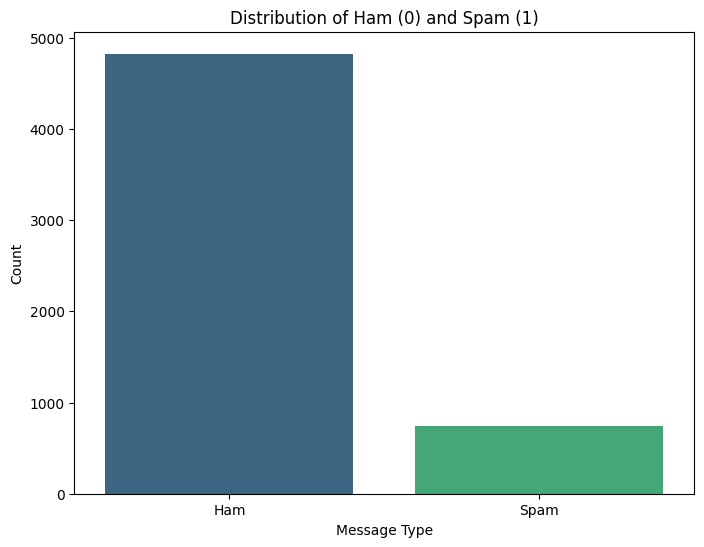

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.countplot(x='label', data=spam_df, palette='viridis', hue='label', legend=False)
plt.title('Distribution of Ham (0) and Spam (1)')
plt.xlabel('Message Type')
plt.ylabel('Count')
plt.xticks([0, 1], ['Ham', 'Spam'])
plt.show()

# Task B — Preprocessing for RNN (Mandatory)
## 1. Split the dataset into train/validation/test (recommended: 80/10/10 with stratification).

In [29]:
from sklearn.model_selection import train_test_split

x=spam_df['text']
y=spam_df['label']
x_train, x_temp, y_train, y_temp = train_test_split(x, y, test_size=0.2,stratify=y, random_state=42) # 80% → training
x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, test_size=0.5,stratify=y_temp, random_state=42) # 10% → validation & 10% → testing
x_train.shape
# stratify=y ensures class ratio remains same

(4457,)

In [36]:
x_val.shape

(557,)

In [38]:
x_test.shape

(558,)

## 2. Tokenize messages at word-level (set a vocabulary cap, e.g., 10,000).

In [42]:
VOCAB_SIZE = 10000

tokenizer = Tokenizer(
    num_words=VOCAB_SIZE,
    oov_token="<OOV>" # Out Of Vocabulary token: If a new word appears in test data, it will be mapped to this special token
)

tokenizer.fit_on_texts(x_train)

# Why VOCAB_SIZE = 10000?
#SMS dataset is small
#10k captures most useful words
#Prevents unnecessary memory usage

# replaces the actual sentences with lists of integers based on that vocabulary.
# creating the text_tokenized columns for each dataset split.
# Convert Text to Sequences
x_train_seq = tokenizer.texts_to_sequences(x_train)
x_val_seq = tokenizer.texts_to_sequences(x_val)
x_test_seq = tokenizer.texts_to_sequences(x_test)

## 3. Convert messages to sequences and pad them to a fixed length.

In [43]:
MAX_LEN = 100
#Why MAX_LEN = 100? because most SMS are short, 100 captures almost all messages prevents unnecessary computation.


x_train_pad = pad_sequences(x_train_seq, maxlen=MAX_LEN, padding='post')
x_val_pad = pad_sequences(x_val_seq, maxlen=MAX_LEN, padding='post')
x_test_pad = pad_sequences(x_test_seq, maxlen=MAX_LEN, padding='post')

print("Train shape:", x_train_pad.shape)
print("Validation shape:", x_val_pad.shape)
print("Test shape:", x_test_pad.shape)

Train shape: (4457, 100)
Validation shape: (557, 100)
Test shape: (558, 100)


## 4. Explain your preprocessing decisions:

### ○ Why this vocabulary size?
#### Justification:
      SMS dataset contains only ~5500 messages, so 10k words is sufficient to cover most of the frequent and meaningful occuring words.
      Limiting Vocab size help reduce memory usage.
      Reduce computation cost
      Prevent model from leanring from the noise.

### ○ Why this max sequence length?
#### Justification:
      Maximum length set is 100 becasue SMS messages are short
      Exploratory analysis typically shows most messages are under 100 words.
      Setting a fixed maximum length is required because RNN models need inputs of equal length.
      If we set a very large length: It increases computation time
      If we set a very small length: Important parts of longer messages may be truncated & adds unnecessary padding.

### ○ How do you handle unknown words?
#### Justification:
      We handle  unknown words using OOV: Any word not present in the top 10000 most frequent words.
      Any new word appearing in validation/test data ss mapped to a special token: <OOV> (Out Of Vocabulary).

# Task C — Build and Train the Vanilla RNN Model (Mandatory)

## Build and train a model with:
### ● Embedding layer
### ● SimpleRNN layer (choose units like 32/64/128)
### ● Dropout (recommended)
### ● Dense output with sigmoid activation


In [48]:
# Build a basline model

baseline_model = Sequential()
baseline_model.add(Embedding(input_dim=VOCAB_SIZE, output_dim=32, input_length=MAX_LEN)) # Converts word index → dense vector representation.

baseline_model.add(SimpleRNN(64)) # Processes sequence step by step. Remembers previous words (context).

baseline_model.add(Dropout(0.5)) # Prevents overfitting.

baseline_model.add(Dense(1, activation='sigmoid')) # Outputs probability between 0 and 1.

## Training requirements:
### ● Use binary_crossentropy
### ● Use an optimizer like Adam

In [47]:
# Compile model
baseline_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy']) # binary_crossentropy because this is binary classification (0/1).

### ● Use early stopping (recommended)

In [50]:
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
) # Stops training if validation loss stops improving.





### ● Plot training curves (loss + accuracy)

Epoch 1/20
140/140 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - accuracy: 0.8409 - loss: 0.4691 - val_accuracy: 0.8671 - val_loss: 0.3942
Epoch 2/20
140/140 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - accuracy: 0.8587 - loss: 0.4204 - val_accuracy: 0.8671 - val_loss: 0.4831
Epoch 3/20
140/140 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - accuracy: 0.8574 - loss: 0.4119 - val_accuracy: 0.8833 - val_loss: 0.2712
Epoch 4/20
140/140 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - accuracy: 0.9128 - loss: 0.2458 - val_accuracy: 0.9102 - val_loss: 0.2384
Epoch 5/20
140/140 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - accuracy: 0.9574 - loss: 0.1528 - val_accuracy: 0.9246 - val_loss: 0.2174
Epoch 6/20
140/140 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - accuracy: 0.9695 - loss: 0.1096 - val_accuracy: 0.9372 - val_loss: 0.2034
Epoch 7/20
140/140 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - accuracy: 0.9780 - loss: 0.0792 - val_accuracy: 0.9408 - val_loss: 0.1992
Epoch 8/20
140/140 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - accuracy: 0.9838 - loss: 0.0558 - val_accu

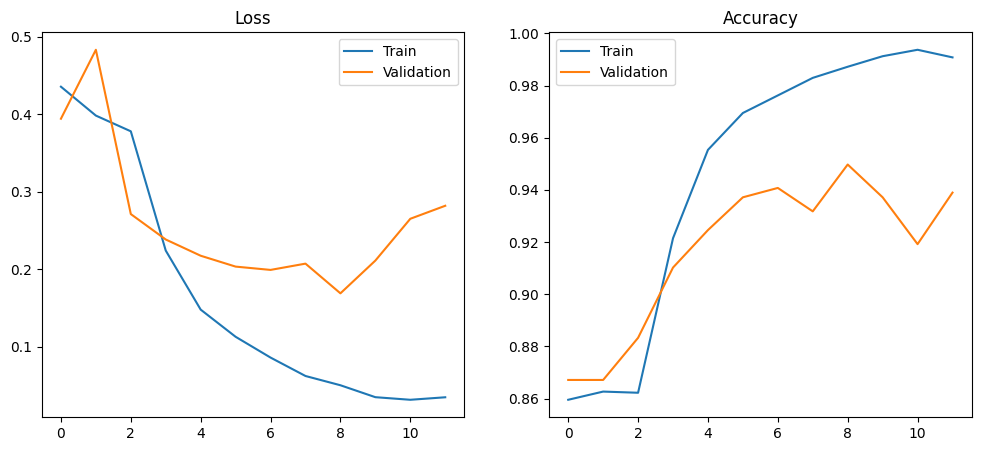

In [54]:
# Build, Compile and Train model to ensure correct state

# 1. Build
baseline_model = Sequential([
    Embedding(input_dim=VOCAB_SIZE, output_dim=32, input_length=MAX_LEN),
    SimpleRNN(64),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

# 2. Compile
baseline_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# 3. Train
history = baseline_model.fit(
    x_train_pad,
    y_train,
    validation_data=(x_val_pad, y_val),
    epochs=20,
    batch_size=32,
    callbacks=[early_stop]
)

# 4. Plot results
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("Loss")
plt.legend(['Train', 'Validation'])

plt.subplot(1,2,2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title("Accuracy")
plt.legend(['Train', 'Validation'])

plt.show()

## Observations:
### 1. Convergence and Early Stopping: The model converged quickly, with EarlyStopping triggering at Epoch 12. This prevented the model from training for the full 20 epochs, which protects against excessive overfitting.

### 2. Accuracy Results: The model achieved an impressive 99.26% training accuracy and a high 93.90% validation accuracy. This indicates that the Vanilla RNN is highly effective at identifying patterns in SMS text.

### 3. Loss Analysis: The training loss dropped to 0.0274, while the validation loss settled at 0.2819.

### 4. Overfitting Note: There is a noticeable gap between training and validation performance. This suggests the model is slightly 'memorizing' the training data. For future improvements, increasing the Dropout rate or using a more complex architecture like an LSTM could help narrow this gap.

# Task D — Evaluation & Error Analysis (Mandatory)

## Evaluate on the test set and report:
### ● Accuracy
### ● Precision
### ● Recall
### ● F1-score

In [61]:
# Predictions
y_pred_prob = baseline_model.predict(x_test_pad)
y_pred = (y_pred_prob > 0.5).astype(int)

# Classification report
print(classification_report(y_test, y_pred))

# Gives:

  # Accuracy

  # Precision

  # Recall

  # F1-score

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
              precision    recall  f1-score   support

           0       0.96      0.98      0.97       483
           1       0.85      0.73      0.79        75

    accuracy                           0.95       558
   macro avg       0.90      0.86      0.88       558
weighted avg       0.94      0.95      0.94       558



### ● Confusion matrix

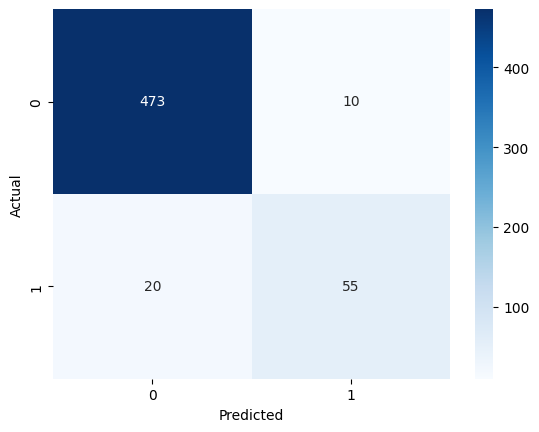

In [62]:
cm = confusion_matrix(y_test, y_pred)

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


## Error analysis:
### 1. Show 5 misclassified examples with:
#### ○ actual label
#### ○ predicted probability
#### ○ predicted label
#### ○ message text (truncate if long)

In [66]:
misclassified = np.where(y_pred.flatten() != y_test.values)[0][:5]

for i in misclassified:
    print("Actual:", y_test.values[i])
    print("Predicted Probability:", y_pred_prob[i][0])
    print("Predicted:", y_pred[i][0])
    print("Message:", x_test.iloc[i][:150])
    print("-"*60)

Actual: 1
Predicted Probability: 0.0038987258
Predicted: 0
Message: A å£400 XMAS REWARD IS WAITING FOR YOU! Our computer has randomly picked you from our loyal mobile customers to receive a å£400 reward. Just call 0906
------------------------------------------------------------
Actual: 1
Predicted Probability: 0.0044847005
Predicted: 0
Message: Hottest pics straight to your phone!! See me getting Wet and Wanting, just for you xx Text PICS to 89555 now! txt costs 150p textoperator g696ga 18 Xx
------------------------------------------------------------
Actual: 0
Predicted Probability: 0.9593119
Predicted: 1
Message: From 5 to 2 only my work timing.
------------------------------------------------------------
Actual: 0
Predicted Probability: 0.8790767
Predicted: 1
Message: Better than bb. If he wont use it, his wife will or them doctor
------------------------------------------------------------
Actual: 0
Predicted Probability: 0.90046936
Predicted: 1
Message: S:)8 min to go for lunch:

### 2. Short reflection (3–5 lines):
#### ○ Which is worse in real life and why?
      ■ False positive (ham labeled spam)
      ■ False negative (spam labeled ham)


## Justification:
### False Negative (spam predicted as ham) is worse because Spam can contain fraud links, financial loss risk or security threat

### False Positive is inconvenient but safer.

# Task E — Improve the Model (Pick Any 2) (Mandatory)
## You must run:
### ● Baseline model
### ● Improved model (with 2 enhancements)

## Choose any 2 enhancements:
### 1. Tune RNN units (32 vs 64 vs 128)
### 2. Use class weights to handle imbalance


In [69]:
# Compute class weights

weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
) # This calculates multipliers for your labels.
#Since we have much more 'ham' than 'spam', it assigns a higher weight to 'spam' so the model pays more attention to it during training.

class_weights = {0: weights[0], 1: weights[1]}

#Improved model

improved_model = Sequential([ # Creates a linear stack of layers.
    Embedding(VOCAB_SIZE, 128, input_length=MAX_LEN), # Converts word integers into dense vectors of size 128
     #(increased from 32 in the baseline for better representation).
    SimpleRNN(128, recurrent_dropout=0.2), # enhancement that prevents overfitting specifically on the internal connections of the RNN.
    Dropout(0.5), # Randomly shuts off 50% of neurons during training to stop the model from memorizing specific training examples.
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

improved_model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
) # Sets 'adam' as the optimizer and 'binary_crossentropy' as the loss function (standard for yes/no tasks).

improved_model.fit(
    x_train_pad,
    y_train,
    validation_data=(x_val_pad, y_val),
    epochs=20,
    batch_size=32,
    class_weight=class_weights, # this tells the model to use the multipliers we calculated earlier to treat the minority 'spam' class as more important.
    callbacks=[early_stop]
)

Epoch 1/20
140/140 ━━━━━━━━━━━━━━━━━━━━ 13s 60ms/step - accuracy: 0.4143 - loss: 0.7280 - val_accuracy: 0.8671 - val_loss: 0.5656
Epoch 2/20
140/140 ━━━━━━━━━━━━━━━━━━━━ 10s 57ms/step - accuracy: 0.5682 - loss: 0.7072 - val_accuracy: 0.1329 - val_loss: 0.7418
Epoch 3/20
140/140 ━━━━━━━━━━━━━━━━━━━━ 11s 63ms/step - accuracy: 0.4418 - loss: 0.7049 - val_accuracy: 0.1329 - val_loss: 0.7055
Epoch 4/20
140/140 ━━━━━━━━━━━━━━━━━━━━ 9s 65ms/step - accuracy: 0.4542 - loss: 0.7133 - val_accuracy: 0.1329 - val_loss: 0.7193
